In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
data = pd.read_json('data/train.json')
test_df = pd.read_json('data/test.json')

# Размер данных
print(f"Размер данных: {data.shape}")

# Список столбцов
print("Столбцы:", data.columns.tolist())

# Целевой столбец
print("Целевой столбец: 'price'")

# Анализ данных
print("\nИнформация о данных:")
print(data.info())

print("\nОписательная статистика:")
print(data.describe())

print("\nМатрица корреляции:")
print(data.corr(numeric_only=True))

# Создание DataFrame с нужными столбцами
df = data[['bathrooms', 'bedrooms', 'interest_level', 'price']].copy()
print("\nDataFrame:")
print(df)

Размер данных: (49352, 15)
Столбцы: ['bathrooms', 'bedrooms', 'building_id', 'created', 'description', 'display_address', 'features', 'latitude', 'listing_id', 'longitude', 'manager_id', 'photos', 'price', 'street_address', 'interest_level']
Целевой столбец: 'price'

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  pho

In [2]:
# Одинаковая обработка для train и test
data['bathrooms'] = data['bathrooms'].replace(0, 1).clip(upper=5)
data['bedrooms'] = data['bedrooms'].clip(upper=6)

test_df['bathrooms'] = test_df['bathrooms'].replace(0, 1).clip(upper=5)
test_df['bedrooms'] = test_df['bedrooms'].clip(upper=6)

df['bathrooms'] = df['bathrooms'].replace(0, 1).clip(1, 5)

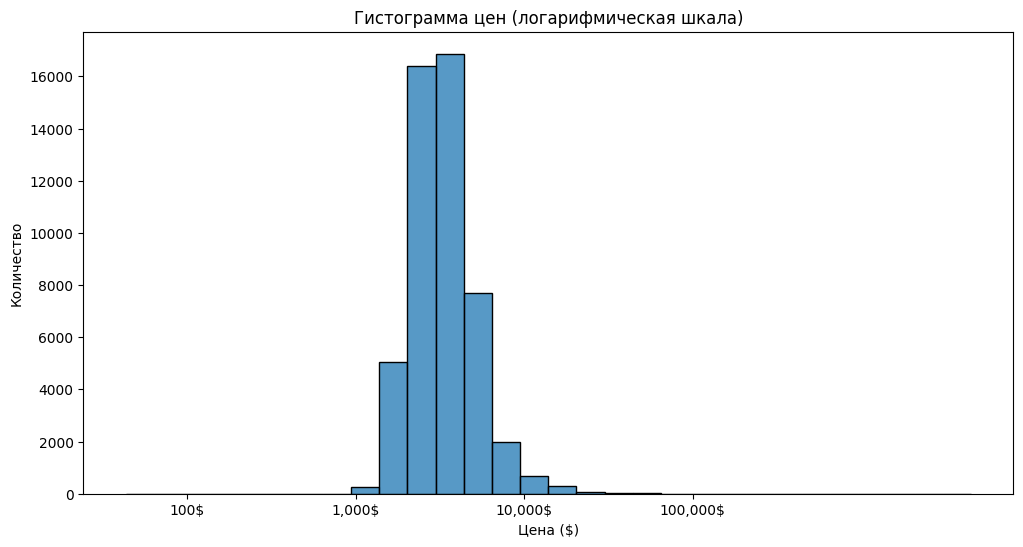

In [3]:
# Гистограмма цены
# plt.figure(figsize=(12, 6))
# plt.hist(np.log1p(df['price']), bins=50)  # log1p для обработки нулей
# plt.title('Гистограмма цен (по бинам)')
# plt.xlabel('log(Цена)')
# plt.ylabel('Количество')
# plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(np.log10(df['price']), bins=30, kde=False)
plt.xticks(
    ticks=[2, 3, 4, 5], 
    labels=['100$', '1,000$', '10,000$', '100,000$']  # Подписи в долларах
)
plt.title('Гистограмма цен (логарифмическая шкала)')
plt.xlabel('Цена ($)')
plt.ylabel('Количество')
plt.show()

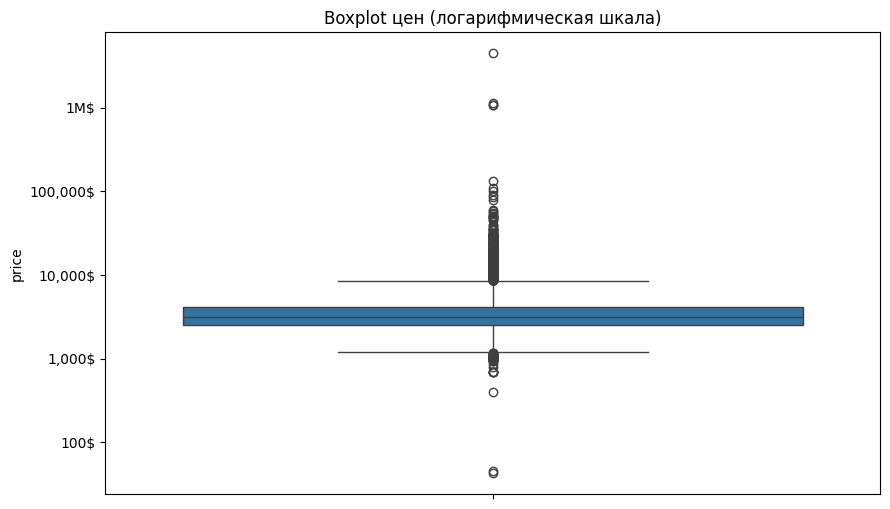

Максимальная цена до обработки: 4,490,000 $


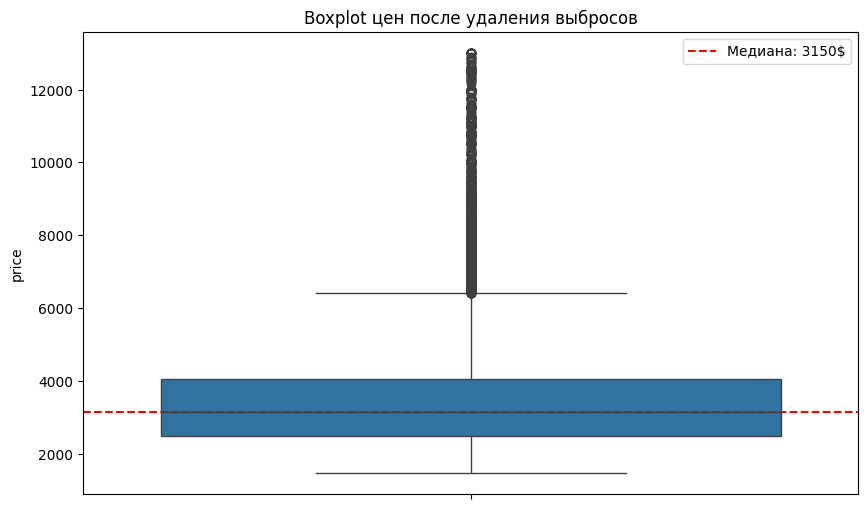

Новый диапазон: 1,475$ - 13,000$


In [4]:
# boxplot с выбросами (исходные данные)
plt.figure(figsize=(10, 6))
sns.boxplot(y=np.log10(df['price']))  # Логарифм по основанию 10
plt.yticks(ticks=[2, 3, 4, 5, 6], 
           labels=['100$', '1,000$', '10,000$', '100,000$', '1M$'])
plt.title('Boxplot цен (логарифмическая шкала)')
plt.show()
print(f"Максимальная цена до обработки: {df['price'].max():,} $") 

# удаляем выбросы
lower_bound = df['price'].quantile(0.01)
upper_bound = df['price'].quantile(0.99)
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]  # Переименовал в df_filtered

# boxplot без выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_filtered['price'])  # Используем отфильтрованные данные
plt.title('Boxplot цен после удаления выбросов')
plt.axhline(y=df_filtered['price'].median(), color='red', linestyle='--', label=f'Медиана: {df_filtered["price"].median():.0f}$')
plt.legend()
plt.show()
print(f"Новый диапазон: {df_filtered['price'].min():,}$ - {df_filtered['price'].max():,}$")

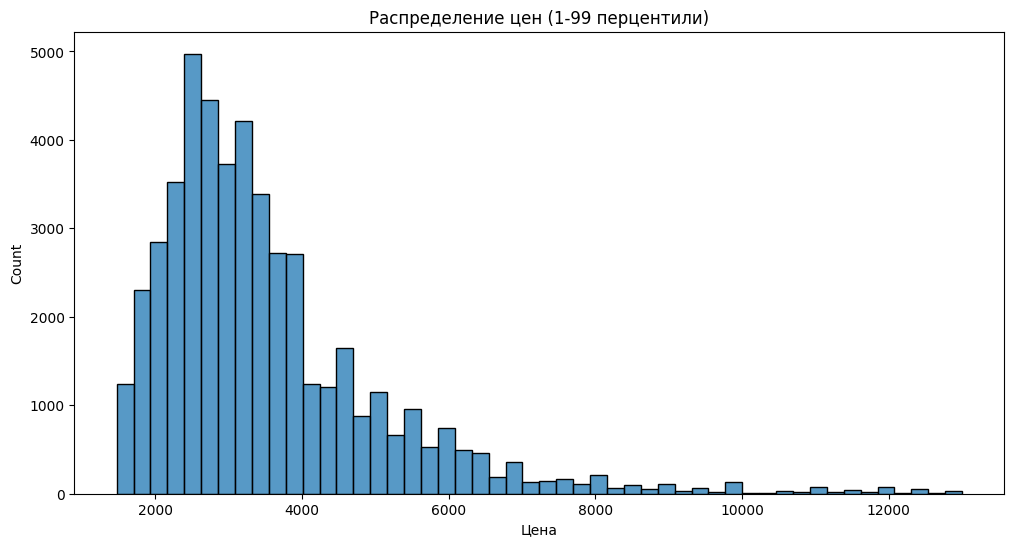

In [5]:
# Гистограмма с разумными границами:
# plt.figure(figsize=(12, 6))
# sns.histplot(df_filtered['price'], bins=50)
# plt.title('Распределение цен ($0-$10k без выбросов)')
# plt.xlabel('Цена')
# plt.ylabel('Количество')
# plt.show()

#Зум на основную массу данных (1-99 перцентили)
q1 = df['price'].quantile(0.01)
q99 = df['price'].quantile(0.99)
plt.figure(figsize=(12, 6))
sns.histplot(df_filtered['price'].clip(lower=q1, upper=q99), bins=50)
plt.title('Распределение цен (1-99 перцентили)')
plt.xlabel('Цена')
plt.show()

Значения interest_level и их количество:
interest_level
low       33697
medium    11116
high       3566
Name: count, dtype: int64


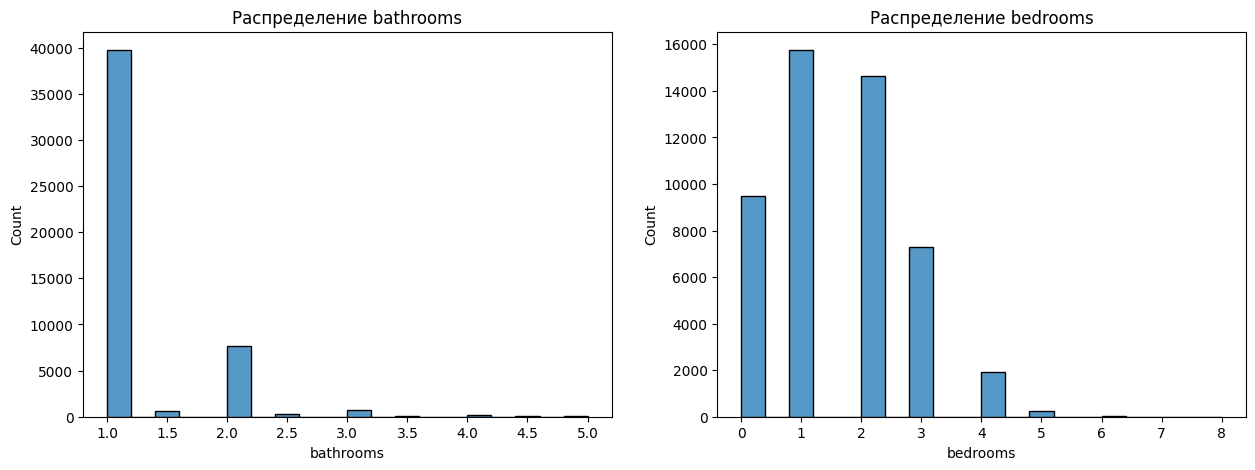

In [6]:
# Анализ interest_level
print("Значения interest_level и их количество:")
print(df_filtered['interest_level'].value_counts())

# Кодирование interest_level
# Для основного DataFrame
df = df.copy()
df['interest_level'] = df['interest_level'].map({'low': 0, 'medium': 1, 'high': 2})
# Для отфильтрованного DataFrame
df_filtered = df_filtered.copy()
df_filtered['interest_level'] = df_filtered['interest_level'].map({'low': 0, 'medium': 1, 'high': 2})

# Гистограммы для bathrooms и bedrooms
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['bathrooms'], bins=20, ax=axes[0])
sns.histplot(df['bedrooms'], bins=20, ax=axes[1])
axes[0].set_title('Распределение bathrooms')
axes[1].set_title('Распределение bedrooms')
plt.show()

**high interest_level:**

Более привлекательная цена

Лучшие характеристики (больше спален/ванных)

Лучшие фото/описание

**low interest_level:**

Завышенная цена

Плохое качество объявления

Непопулярное местоположение

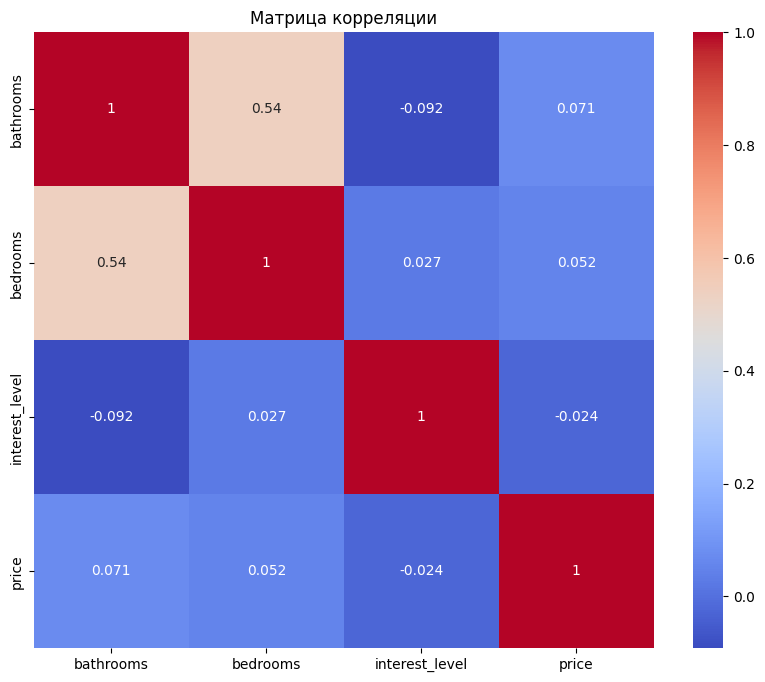

In [7]:
# Матрица корреляции и тепловая карта
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Сильная связь:

bathrooms и bedrooms (+0.53) - больше спален → больше ванных

Слабая связь с ценой:

bedrooms (+0.052) и bathrooms (+0.07) слабо влияют на цену

interest_level (-0.024) - незначительное влияние на цену

Парадоксально слабые отрицательные связи с уровнем интереса:

bathrooms → interest_level: -0.083

bedrooms → interest_level: 0.027

interest_level → price: -0.024

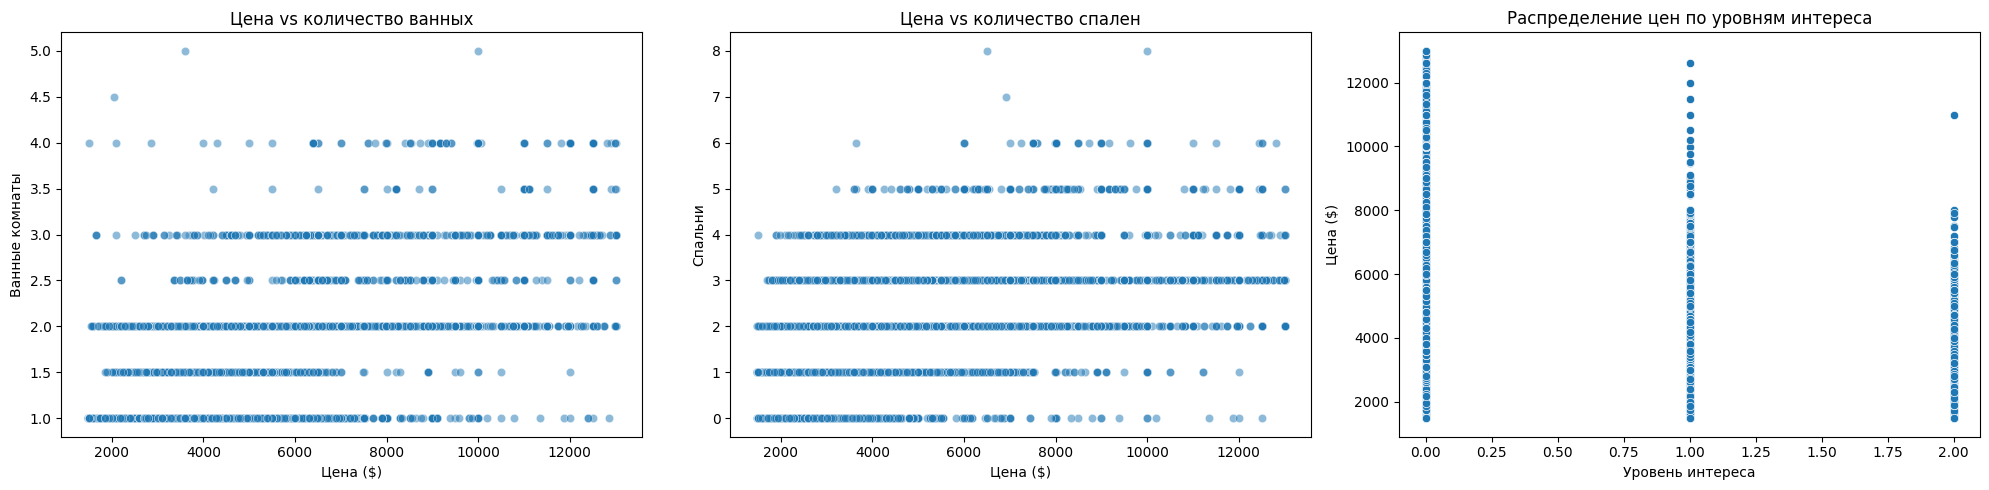

In [8]:
# Диаграммы рассеивания
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. Price vs bathrooms
sns.scatterplot(x='price', y='bathrooms', data=df_filtered, ax=axes[0], alpha=0.5)
#axes[0].set_xlim(0, 10000)
axes[0].set_title("Цена vs количество ванных")
axes[0].set_xlabel("Цена ($)")
axes[0].set_ylabel("Ванные комнаты")

# 2. Price vs bedrooms
sns.scatterplot(x='price', y='bedrooms', data=df_filtered, ax=axes[1], alpha=0.5)
#axes[1].set_xlim(0, 10000)
axes[1].set_title("Цена vs количество спален")
axes[1].set_xlabel("Цена ($)")
axes[1].set_ylabel("Спальни")

# 3. Price vs interest_level (с boxplot будут выбросы)
sns.scatterplot(x='interest_level', y='price', data=df_filtered, ax=axes[2])
#axes[2].set_ylim(0, 10000)
axes[2].set_title("Распределение цен по уровням интереса")
axes[2].set_xlabel("Уровень интереса")
axes[2].set_ylabel("Цена ($)")

plt.tight_layout()
plt.show()

Кажется, цена слабо зависит от базовых характеристик, надо анализировать остальные факторы

___________________________________________________________________________________________________________________________________________________________

In [9]:
# Перепроверяем данные
print(df[['bathrooms', 'bedrooms', 'interest_level', 'price']].head())

    bathrooms  bedrooms  interest_level  price
4         1.0         1               1   2400
6         1.0         2               0   3800
9         1.0         2               1   3495
10        1.5         3               1   3000
15        1.0         0               0   2795


In [10]:
# Создаем 3 новых признака
df['bathrooms_squared'] = df['bathrooms'] ** 2.0
df['bedrooms_squared'] = df['bedrooms'] ** 2.0
df['interest_squared'] = df['interest_level'] ** 2.0

# Проверяем результат
print(df[['bathrooms', 'bathrooms_squared', 
         'bedrooms', 'bedrooms_squared',
         'interest_level', 'interest_squared']].head())

    bathrooms  bathrooms_squared  bedrooms  bedrooms_squared  interest_level  \
4         1.0               1.00         1               1.0               1   
6         1.0               1.00         2               4.0               0   
9         1.0               1.00         2               4.0               1   
10        1.5               2.25         3               9.0               1   
15        1.0               1.00         0               0.0               0   

    interest_squared  
4                1.0  
6                0.0  
9                1.0  
10               1.0  
15               0.0  


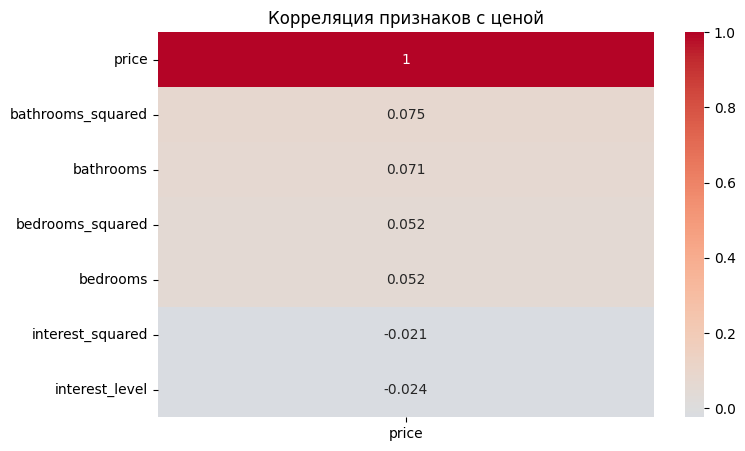

In [11]:
# Вычисляем матрицу корреляции
corr_matrix = df[['bathrooms', 'bedrooms', 'interest_level',
                 'bathrooms_squared', 'bedrooms_squared', 'interest_squared',
                 'price']].corr()

# Визуализируем только корреляции с ценой
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix[['price']].sort_values('price', ascending=False),
            annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция признаков с ценой')
plt.show()

Квадратные признаки немного увеличили корреляцию, но незначительно

In [12]:
# Копируем данные, чтобы не потерять исходные
test_df_clean = test_df.copy()

# Заменяем 0 ванных на 1 (предполагаем, что минимум 1 ванная)
test_df_clean['bathrooms'] = test_df_clean['bathrooms'].replace(0, 1)

# Ограничиваем максимальные значения: квартир с больше чем 5 ванными не бывает, 7 спален тоже перебор
test_df_clean['bathrooms'] = test_df_clean['bathrooms'].clip(upper=5)
test_df_clean['bedrooms'] = test_df_clean['bedrooms'].clip(upper=6)

# Проверяем результат
print(test_df_clean[['bathrooms', 'bedrooms']].describe())

          bathrooms      bedrooms
count  74659.000000  74659.000000
mean       1.217214      1.544609
std        0.487884      1.106774
min        1.000000      0.000000
25%        1.000000      1.000000
50%        1.000000      1.000000
75%        1.000000      2.000000
max        5.000000      6.000000


In [13]:
# Выделяем фичи и целевую переменную из очищенных данных
X = df_filtered[['bathrooms', 'bedrooms']]
y = df_filtered['price']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализируем с degree=10
poly = PolynomialFeatures(degree=10, include_bias=False)

# Преобразуем обучающие данные
X_train_poly = poly.fit_transform(X_train)

# Преобразуем тестовые данные
X_test_poly = poly.transform(X_test)

# Для финального предсказания преобразуем реальные тестовые данные
final_test_poly = poly.transform(test_df_clean[['bathrooms', 'bedrooms']])

# Преобразуем в DataFrame для наглядности
# train_poly_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out())
# test_poly_df = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out())
# final_poly_df = pd.DataFrame(final_test_poly, columns=poly.get_feature_names_out())

print("\nПервые 5 строк преобразованных ОБУЧАЮЩИХ данных:")
print(pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out()).head())

print("\nПервые 5 строк преобразованных ТЕСТОВЫХ данных:")
print(pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out()).head())


Первые 5 строк преобразованных ОБУЧАЮЩИХ данных:
   bathrooms  bedrooms  bathrooms^2  bathrooms bedrooms  bedrooms^2  \
0        1.0       0.0          1.0                 0.0         0.0   
1        1.0       3.0          1.0                 3.0         9.0   
2        1.0       2.0          1.0                 2.0         4.0   
3        1.0       1.0          1.0                 1.0         1.0   
4        1.0       2.0          1.0                 2.0         4.0   

   bathrooms^3  bathrooms^2 bedrooms  bathrooms bedrooms^2  bedrooms^3  \
0          1.0                   0.0                   0.0         0.0   
1          1.0                   3.0                   9.0        27.0   
2          1.0                   2.0                   4.0         8.0   
3          1.0                   1.0                   1.0         1.0   
4          1.0                   2.0                   4.0         8.0   

   bathrooms^4  ...  bathrooms^9 bedrooms  bathrooms^8 bedrooms^2  \
0        

In [14]:
# Инициализация моделей
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=21),
    'NaiveMean': DummyRegressor(strategy='mean'), # предсказывает среднее значение цены из обучающей выборки
    'NaiveMedian': DummyRegressor(strategy='median') # предсказывает медиану цены
}

# Создание таблиц для результатов
result_MAE = [] # Средняя абсолютная ошибка. Показывает, на сколько в среднем ошибается модель
result_RMSE = [] # Корень из средней квадратичной ошибки. Более строгая метрика, т.к. большие ошибки штрафуются сильнее

In [15]:
# Обучение и оценка
for name, model in models.items():
    model.fit(X_train_poly, y_train)
    
    # Прогнозы
    train_pred = model.predict(X_train_poly)
    test_pred = model.predict(X_test_poly)
    
    # Метрики
    mae_train = mean_absolute_error(y_train, train_pred)
    mae_test = mean_absolute_error(y_test, test_pred)
    rmse_train = mean_squared_error(y_train, train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, test_pred, squared=False)
    
    # Запись результатов
    result_MAE.append({
        'model': name,
        'train': mae_train,
        'test': mae_test
    })
    
    result_RMSE.append({
        'model': name,
        'train': rmse_train,
        'test': rmse_test
    })

    # Сохранение прогнозов для нужных моделей
    if name == 'LinearRegression':
        df_filtered['lr_pred'] = model.predict(poly.transform(X))
    elif name == 'DecisionTree':
        df_filtered['dt_pred'] = model.predict(poly.transform(X))

# Создание итоговых DataFrame из списков
result_MAE = pd.DataFrame(result_MAE)
result_RMSE = pd.DataFrame(result_RMSE)

# Вывод результатов
print("MAE Results:")
print(result_MAE.sort_values('test'))
print("\nRMSE Results:")
print(result_RMSE.sort_values('test'))

MAE Results:
              model        train         test
1      DecisionTree   755.176095   758.591966
3       NaiveMedian  1084.589257  1092.695329
2         NaiveMean  1137.760556  1143.077343
0  LinearRegression   755.176357  5135.725808

RMSE Results:
              model        train           test
1      DecisionTree  1076.507632    1088.464449
2         NaiveMean  1599.229452    1591.302875
3       NaiveMedian  1645.449541    1639.375180
0  LinearRegression  1076.507632  430579.728392


ИТОГ:

Decision Tree работает лучше всего: самая низкая ошибка на тестах, разница между train и test минимальна

LinearRegression переобучилась, можно сделать регуляризацию (лучше) или поменять degree у полиномиальной на 2-3

**Добавим наглядности**

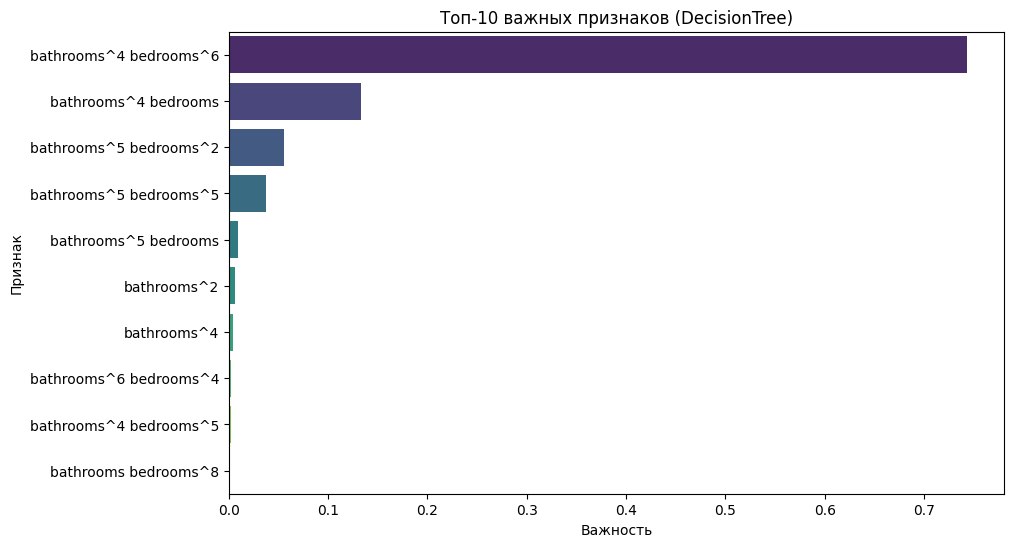

In [22]:
# Какие полиномиальные признаки наиболее важны
dt_model = models['DecisionTree']
feature_importance = pd.DataFrame({
    'feature': poly.get_feature_names_out(),
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', hue='feature', palette='viridis')
plt.title('Топ-10 важных признаков (DecisionTree)')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()